# 3D Atrophy Map 

And easily use below features:
1. Transforms for dictionary format data.
1. Load Nifti image with metadata.
1. Add channel dim to the data if no channel dimension.
1. Scale medical image intensity with expected range.
1. Crop out a batch of balanced images based on positive / negative label ratio.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNet model, MSE loss function, Mean MSE metric for image-to-image prediction.
1. Sliding window inference method.
1. Deterministic training for reproducibility.

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 960 kB 5.4 MB/s 
     |████████████████████████████████| 259 kB 65.8 MB/s 


In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    RandSpatialCropd,
    SaveImaged,
    ScaleIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)
from monai.metrics import MSEMetric
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import numpy as np


## Setup imports

In [3]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


print_config()

MONAI version: 0.10.dev2228
Numpy version: 1.21.6
Pytorch version: 1.12.0+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: b287dfc6a7c397523ba67e10a0436099fb0a44f7
MONAI __file__: /usr/local/lib/python3.7/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.13.0+cu113
tqdm version: 4.64.0
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Set dataset path

In [4]:
root_dir = '/content/drive/MyDrive/data/'
print(root_dir)

from google.colab import drive
drive.mount('/content/drive')


/content/drive/MyDrive/data/
Mounted at /content/drive


In [5]:
train_images = sorted(glob.glob(os.path.join(root_dir, "im*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(root_dir, "seg*.nii.gz")))

data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[20:], data_dicts[:20]

# Check length of the images and each set
print(len(train_images))
print(len(train_files))
print(len(val_files))

92
72
20


## Set deterministic training for reproducibility

In [6]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `AddChanneld` as the original data doesn't have channel dim, add 1 dim to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.
1. `EnsureTyped` converts the numpy array to PyTorch Tensor for further steps.

In [7]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        #Orientationd(keys=["image", "label"], axcodes="RAS"),
        RandSpatialCropd(keys=["image", "label"],roi_size=(128, 96, 128),random_size=False),
        #Spacingd(keys=["image", "label"], pixdim=(
        #    1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityd(
            keys=["image"], minv=0, maxv=1,
        ),
        #CropForegroundd(keys=["image", "label"], source_key="image"),
        #RandCropByPosNegLabeld(
        #    keys=["image", "label"],
        #    label_key="label",
        #    spatial_size=(128, 96, 128),
        #    pos=1,
        #    neg=1,
        #    num_samples=4,
        #    image_key="image",
        #    image_threshold=0,
        #),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        #Orientationd(keys=["image", "label"], axcodes="RAS"),
        #Spacingd(keys=["image", "label"], pixdim=(
        #    1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        #ScaleIntensityRanged(
        #    keys=["image"], a_min=-57, a_max=164,
        #    b_min=0.0, b_max=1.0, clip=True,
        #),
        ScaleIntensityd(
            keys=["image"], minv=0, maxv=1,
        ),
        #CropForegroundd(keys=["image", "label"], source_key="image"),
        RandSpatialCropd(keys=["image","label"],roi_size=(128, 96, 128),random_size=False),
        EnsureTyped(keys=["image", "label"]),
    ]
)

## Check transforms in DataLoader

image shape: (128, 96, 128), label shape: (128, 96, 128)


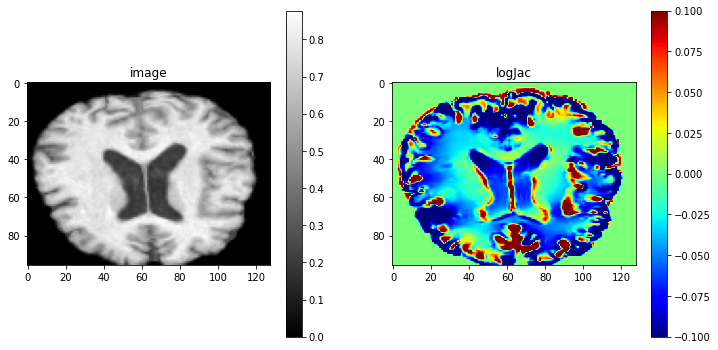

In [8]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(np.rot90(image[:, :, 80]), cmap="gray")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("logJac")
plt.imshow(np.rot90(label[:, :, 80]),cmap='jet')
plt.clim(vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [9]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=2)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

Loading dataset: 100%|██████████| 20/20 [00:01<00:00, 11.21it/s]


## Create Model, Loss, Optimizer

In [10]:
import torch
import torch.nn.functional as F
from math import exp
import numpy as np


# Calculating one-dimensional Gaussian distribution vector
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()


#  Create a Gaussian nucleus, and the matrix multiplication is obtained by two one-dimensional Gaussian distribution vectors.
#  You can set the CHANNEL parameter to 3 channels
def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window


#  Calculate SSIM
#  Directly use the formula of SSIM, but when calculating the average, it is not directly asking for average average, but is replaced by a normalized Gaussian nuclear volume.
#  The formula VAR (X) = E [x ^ 2] -e [x] ^ 2, COV (X, Y) = E [xY] -e [x] e [y] is used when calculating the variance and the covariance.
#  As mentioned earlier, the above-mentioned operation is replaced by Gaussian nuclear volume.
def ssim(img1, img2, window_size=11, window=None, size_average=True, full=False, val_range=None):
    # Value range can be different from 255. Other common ranges are 1 (sigmoid) and 2 (tanh).
    if val_range is None:
        if torch.max(img1) > 128:
            max_val = 255
        else:
            max_val = 1

        if torch.min(img1) < -0.5:
            min_val = -1
        else:
            min_val = 0
        L = max_val - min_val
    else:
        L = val_range

    padd = 0
    (_, channel, height, width) = img1.size()
    if window is None:
        real_size = min(window_size, height, width)
        window = create_window(real_size, channel=channel).to(img1.device)

    mu1 = F.conv2d(img1, window, padding=padd, groups=channel)
    mu2 = F.conv2d(img2, window, padding=padd, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=padd, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=padd, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=padd, groups=channel) - mu1_mu2

    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2

    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2
    cs = torch.mean(v1 / v2)  # contrast sensitivity

    ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)

    if size_average:
        ret = ssim_map.mean()
    else:
        ret = ssim_map.mean(1).mean(1).mean(1)

    if full:
        return ret, cs
    return ret



# Classes to re-use window
class SSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True, val_range=None):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.val_range = val_range

        # Assume 1 channel for SSIM
        self.channel = 1
        self.window = create_window(window_size)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.dtype == img1.dtype:
            window = self.window
        else:
            window = create_window(self.window_size, channel).to(img1.device).type(img1.dtype)
            self.window = window
            self.channel = channel

        return ssim(img1, img2, window=window, window_size=self.window_size, size_average=self.size_average)

In [11]:
#pip install pytorch-msssim


In [12]:
#from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM


# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=0,
).to(device)

loss_function = torch.nn.MSELoss()
#loss_function = torch.nn.HuberLoss(reduction='mean')
#loss_function = SSIM(data_range=1, size_average=False, channel=3)

lr=1e-3
optimizer = torch.optim.Adam(model.parameters(), lr)
mse_metric = MSEMetric(reduction="mean")


## Execute a typical PyTorch training process

----------
epoch 1/40
1/9, train_loss: 1.7410
2/9, train_loss: 0.8397
3/9, train_loss: 0.5010
4/9, train_loss: 0.3572
5/9, train_loss: 0.2703
6/9, train_loss: 0.2076
7/9, train_loss: 0.1711
8/9, train_loss: 0.1575
9/9, train_loss: 0.1464
epoch 1 average loss: 0.4880


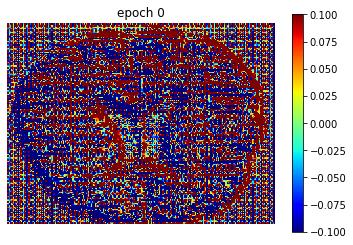

----------
epoch 2/40
1/9, train_loss: 0.1314
2/9, train_loss: 0.1166
3/9, train_loss: 0.1030
4/9, train_loss: 0.0924
5/9, train_loss: 0.0850
6/9, train_loss: 0.0814
7/9, train_loss: 0.0769
8/9, train_loss: 0.0701
9/9, train_loss: 0.0642
epoch 2 average loss: 0.0912


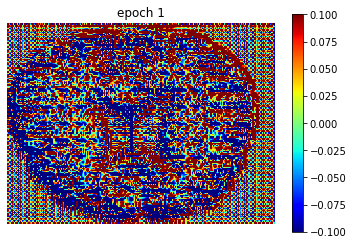

saved new best metric model
current epoch: 2 current mean MSE: 0.0579
best mean MSE: 0.0579 at epoch: 2
----------
epoch 3/40
1/9, train_loss: 0.0572
2/9, train_loss: 0.0568
3/9, train_loss: 0.0533
4/9, train_loss: 0.0487
5/9, train_loss: 0.0471
6/9, train_loss: 0.0447
7/9, train_loss: 0.0427
8/9, train_loss: 0.0423
9/9, train_loss: 0.0401
epoch 3 average loss: 0.0481


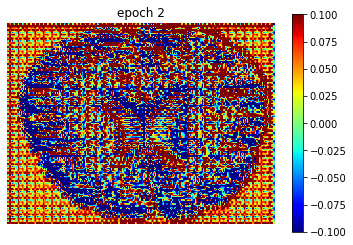

----------
epoch 4/40
1/9, train_loss: 0.0385
2/9, train_loss: 0.0356
3/9, train_loss: 0.0331
4/9, train_loss: 0.0336
5/9, train_loss: 0.0330
6/9, train_loss: 0.0287
7/9, train_loss: 0.0295
8/9, train_loss: 0.0280
9/9, train_loss: 0.0272
epoch 4 average loss: 0.0319


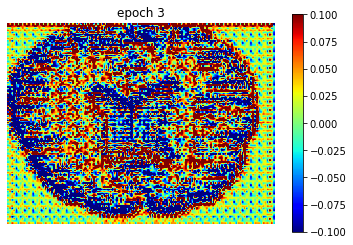

saved new best metric model
current epoch: 4 current mean MSE: 0.0252
best mean MSE: 0.0252 at epoch: 4
----------
epoch 5/40
1/9, train_loss: 0.0264
2/9, train_loss: 0.0249
3/9, train_loss: 0.0240
4/9, train_loss: 0.0252
5/9, train_loss: 0.0233
6/9, train_loss: 0.0227
7/9, train_loss: 0.0221
8/9, train_loss: 0.0207
9/9, train_loss: 0.0222
epoch 5 average loss: 0.0235


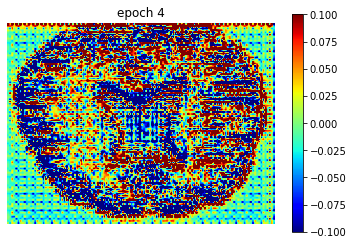

----------
epoch 6/40
1/9, train_loss: 0.0210
2/9, train_loss: 0.0196
3/9, train_loss: 0.0197
4/9, train_loss: 0.0190
5/9, train_loss: 0.0185
6/9, train_loss: 0.0173
7/9, train_loss: 0.0190
8/9, train_loss: 0.0178
9/9, train_loss: 0.0174
epoch 6 average loss: 0.0188


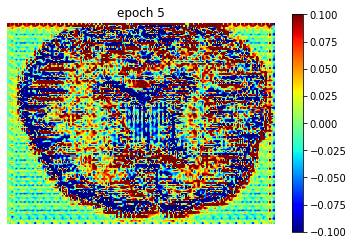

saved new best metric model
current epoch: 6 current mean MSE: 0.0163
best mean MSE: 0.0163 at epoch: 6
----------
epoch 7/40
1/9, train_loss: 0.0169
2/9, train_loss: 0.0167
3/9, train_loss: 0.0161
4/9, train_loss: 0.0152
5/9, train_loss: 0.0160
6/9, train_loss: 0.0162
7/9, train_loss: 0.0150
8/9, train_loss: 0.0157
9/9, train_loss: 0.0160
epoch 7 average loss: 0.0160


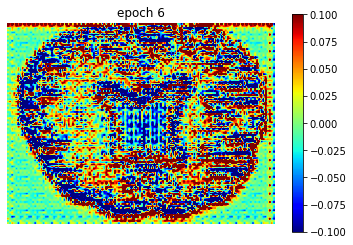

----------
epoch 8/40
1/9, train_loss: 0.0144
2/9, train_loss: 0.0154
3/9, train_loss: 0.0147
4/9, train_loss: 0.0138
5/9, train_loss: 0.0139
6/9, train_loss: 0.0147
7/9, train_loss: 0.0139
8/9, train_loss: 0.0120
9/9, train_loss: 0.0134
epoch 8 average loss: 0.0140


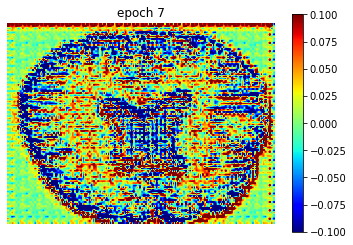

saved new best metric model
current epoch: 8 current mean MSE: 0.0126
best mean MSE: 0.0126 at epoch: 8
----------
epoch 9/40
1/9, train_loss: 0.0141
2/9, train_loss: 0.0118
3/9, train_loss: 0.0131
4/9, train_loss: 0.0120
5/9, train_loss: 0.0122
6/9, train_loss: 0.0126
7/9, train_loss: 0.0126
8/9, train_loss: 0.0130
9/9, train_loss: 0.0117
epoch 9 average loss: 0.0126


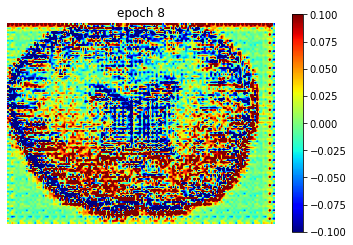

----------
epoch 10/40
1/9, train_loss: 0.0123
2/9, train_loss: 0.0113
3/9, train_loss: 0.0125
4/9, train_loss: 0.0119
5/9, train_loss: 0.0113
6/9, train_loss: 0.0113
7/9, train_loss: 0.0104
8/9, train_loss: 0.0113
9/9, train_loss: 0.0101
epoch 10 average loss: 0.0114


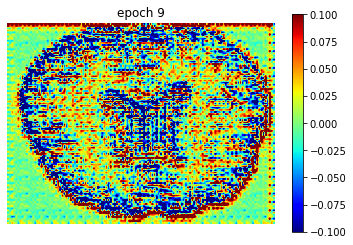

saved new best metric model
current epoch: 10 current mean MSE: 0.0104
best mean MSE: 0.0104 at epoch: 10
----------
epoch 11/40
1/9, train_loss: 0.0110
2/9, train_loss: 0.0104
3/9, train_loss: 0.0114
4/9, train_loss: 0.0103
5/9, train_loss: 0.0103
6/9, train_loss: 0.0098
7/9, train_loss: 0.0103
8/9, train_loss: 0.0096
9/9, train_loss: 0.0106
epoch 11 average loss: 0.0104


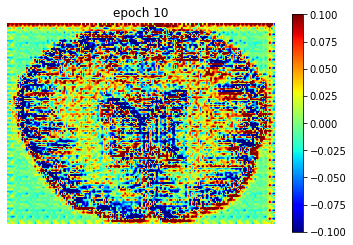

----------
epoch 12/40
1/9, train_loss: 0.0102
2/9, train_loss: 0.0101
3/9, train_loss: 0.0097
4/9, train_loss: 0.0096
5/9, train_loss: 0.0095
6/9, train_loss: 0.0092
7/9, train_loss: 0.0093
8/9, train_loss: 0.0093
9/9, train_loss: 0.0094
epoch 12 average loss: 0.0096


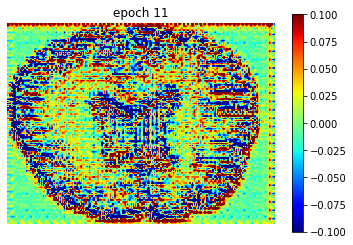

saved new best metric model
current epoch: 12 current mean MSE: 0.0089
best mean MSE: 0.0089 at epoch: 12
----------
epoch 13/40
1/9, train_loss: 0.0095
2/9, train_loss: 0.0091
3/9, train_loss: 0.0087
4/9, train_loss: 0.0088
5/9, train_loss: 0.0091
6/9, train_loss: 0.0089
7/9, train_loss: 0.0083
8/9, train_loss: 0.0086
9/9, train_loss: 0.0089
epoch 13 average loss: 0.0089


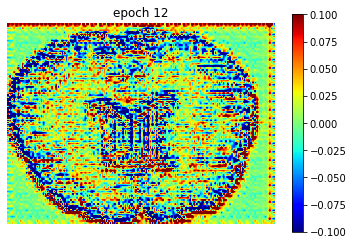

----------
epoch 14/40
1/9, train_loss: 0.0086
2/9, train_loss: 0.0090
3/9, train_loss: 0.0084
4/9, train_loss: 0.0086
5/9, train_loss: 0.0082
6/9, train_loss: 0.0077
7/9, train_loss: 0.0081
8/9, train_loss: 0.0075
9/9, train_loss: 0.0084
epoch 14 average loss: 0.0083


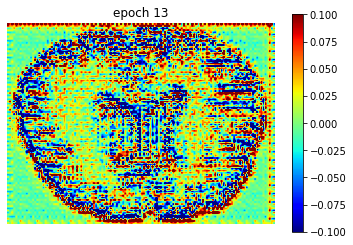

saved new best metric model
current epoch: 14 current mean MSE: 0.0077
best mean MSE: 0.0077 at epoch: 14
----------
epoch 15/40
1/9, train_loss: 0.0081
2/9, train_loss: 0.0075
3/9, train_loss: 0.0077
4/9, train_loss: 0.0080
5/9, train_loss: 0.0073
6/9, train_loss: 0.0075
7/9, train_loss: 0.0072
8/9, train_loss: 0.0079
9/9, train_loss: 0.0080
epoch 15 average loss: 0.0077


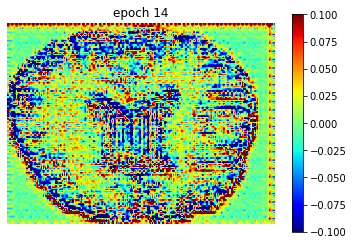

----------
epoch 16/40
1/9, train_loss: 0.0074
2/9, train_loss: 0.0076
3/9, train_loss: 0.0070
4/9, train_loss: 0.0071
5/9, train_loss: 0.0075
6/9, train_loss: 0.0073
7/9, train_loss: 0.0070
8/9, train_loss: 0.0071
9/9, train_loss: 0.0071
epoch 16 average loss: 0.0072


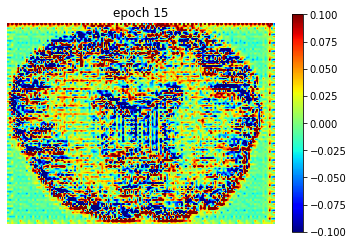

saved new best metric model
current epoch: 16 current mean MSE: 0.0068
best mean MSE: 0.0068 at epoch: 16
----------
epoch 17/40
1/9, train_loss: 0.0070
2/9, train_loss: 0.0067
3/9, train_loss: 0.0074
4/9, train_loss: 0.0072
5/9, train_loss: 0.0072
6/9, train_loss: 0.0063
7/9, train_loss: 0.0071
8/9, train_loss: 0.0061
9/9, train_loss: 0.0063
epoch 17 average loss: 0.0068


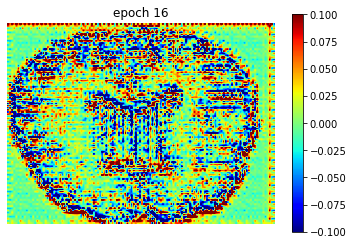

----------
epoch 18/40
1/9, train_loss: 0.0060
2/9, train_loss: 0.0062
3/9, train_loss: 0.0070
4/9, train_loss: 0.0063
5/9, train_loss: 0.0069
6/9, train_loss: 0.0064
7/9, train_loss: 0.0061
8/9, train_loss: 0.0058
9/9, train_loss: 0.0069
epoch 18 average loss: 0.0064


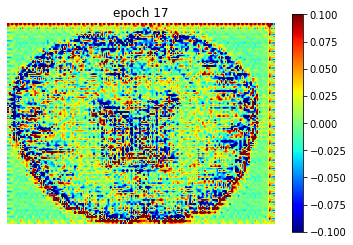

saved new best metric model
current epoch: 18 current mean MSE: 0.0060
best mean MSE: 0.0060 at epoch: 18
----------
epoch 19/40
1/9, train_loss: 0.0061
2/9, train_loss: 0.0061
3/9, train_loss: 0.0067
4/9, train_loss: 0.0066
5/9, train_loss: 0.0056
6/9, train_loss: 0.0057
7/9, train_loss: 0.0059
8/9, train_loss: 0.0068
9/9, train_loss: 0.0052
epoch 19 average loss: 0.0061


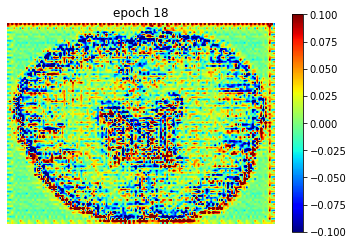

----------
epoch 20/40
1/9, train_loss: 0.0060
2/9, train_loss: 0.0057
3/9, train_loss: 0.0063
4/9, train_loss: 0.0053
5/9, train_loss: 0.0061
6/9, train_loss: 0.0060
7/9, train_loss: 0.0055
8/9, train_loss: 0.0054
9/9, train_loss: 0.0055
epoch 20 average loss: 0.0058


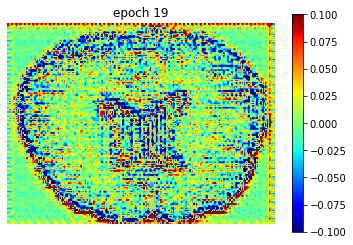

saved new best metric model
current epoch: 20 current mean MSE: 0.0054
best mean MSE: 0.0054 at epoch: 20
----------
epoch 21/40
1/9, train_loss: 0.0060
2/9, train_loss: 0.0058
3/9, train_loss: 0.0060
4/9, train_loss: 0.0054
5/9, train_loss: 0.0057
6/9, train_loss: 0.0052
7/9, train_loss: 0.0051
8/9, train_loss: 0.0050
9/9, train_loss: 0.0051
epoch 21 average loss: 0.0055


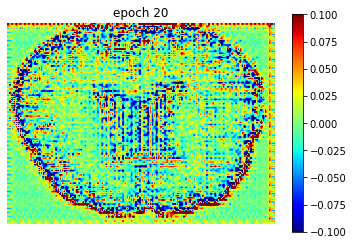

----------
epoch 22/40
1/9, train_loss: 0.0059
2/9, train_loss: 0.0050
3/9, train_loss: 0.0053
4/9, train_loss: 0.0051
5/9, train_loss: 0.0049
6/9, train_loss: 0.0048
7/9, train_loss: 0.0056
8/9, train_loss: 0.0050
9/9, train_loss: 0.0051
epoch 22 average loss: 0.0052


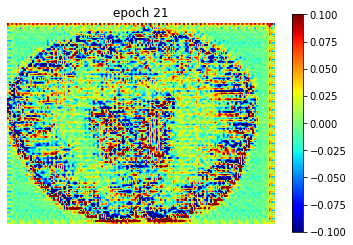

saved new best metric model
current epoch: 22 current mean MSE: 0.0049
best mean MSE: 0.0049 at epoch: 22
----------
epoch 23/40
1/9, train_loss: 0.0055
2/9, train_loss: 0.0049
3/9, train_loss: 0.0050
4/9, train_loss: 0.0047
5/9, train_loss: 0.0050
6/9, train_loss: 0.0049
7/9, train_loss: 0.0045
8/9, train_loss: 0.0053
9/9, train_loss: 0.0048
epoch 23 average loss: 0.0050


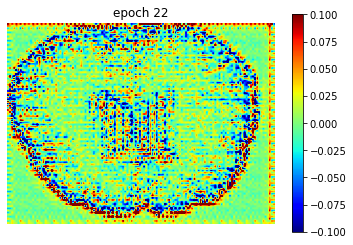

----------
epoch 24/40
1/9, train_loss: 0.0046
2/9, train_loss: 0.0050
3/9, train_loss: 0.0046
4/9, train_loss: 0.0043
5/9, train_loss: 0.0048
6/9, train_loss: 0.0049
7/9, train_loss: 0.0047
8/9, train_loss: 0.0050
9/9, train_loss: 0.0049
epoch 24 average loss: 0.0048


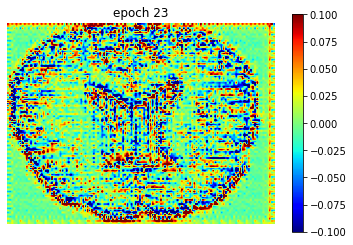

saved new best metric model
current epoch: 24 current mean MSE: 0.0045
best mean MSE: 0.0045 at epoch: 24
----------
epoch 25/40
1/9, train_loss: 0.0049
2/9, train_loss: 0.0051
3/9, train_loss: 0.0043
4/9, train_loss: 0.0046
5/9, train_loss: 0.0050
6/9, train_loss: 0.0043
7/9, train_loss: 0.0041
8/9, train_loss: 0.0042
9/9, train_loss: 0.0045
epoch 25 average loss: 0.0046


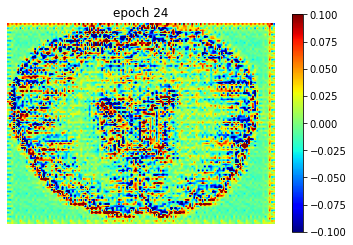

----------
epoch 26/40
1/9, train_loss: 0.0045
2/9, train_loss: 0.0050
3/9, train_loss: 0.0046
4/9, train_loss: 0.0046
5/9, train_loss: 0.0042
6/9, train_loss: 0.0042
7/9, train_loss: 0.0041
8/9, train_loss: 0.0039
9/9, train_loss: 0.0043
epoch 26 average loss: 0.0044


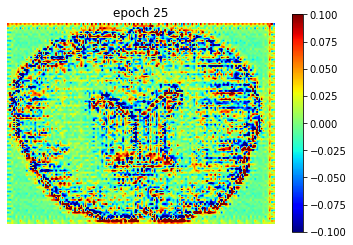

saved new best metric model
current epoch: 26 current mean MSE: 0.0042
best mean MSE: 0.0042 at epoch: 26
----------
epoch 27/40
1/9, train_loss: 0.0038
2/9, train_loss: 0.0045
3/9, train_loss: 0.0039
4/9, train_loss: 0.0043
5/9, train_loss: 0.0044
6/9, train_loss: 0.0048
7/9, train_loss: 0.0038
8/9, train_loss: 0.0038
9/9, train_loss: 0.0044
epoch 27 average loss: 0.0042


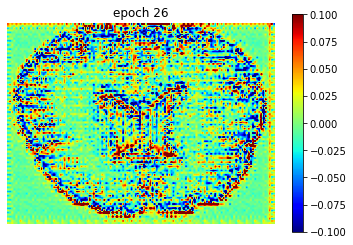

----------
epoch 28/40
1/9, train_loss: 0.0042
2/9, train_loss: 0.0044
3/9, train_loss: 0.0038
4/9, train_loss: 0.0038
5/9, train_loss: 0.0041
6/9, train_loss: 0.0040
7/9, train_loss: 0.0041
8/9, train_loss: 0.0043
9/9, train_loss: 0.0038
epoch 28 average loss: 0.0040


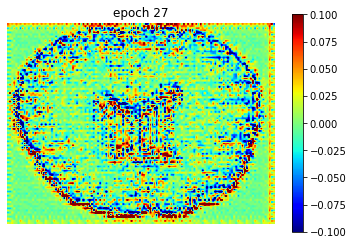

saved new best metric model
current epoch: 28 current mean MSE: 0.0039
best mean MSE: 0.0039 at epoch: 28
----------
epoch 29/40
1/9, train_loss: 0.0043
2/9, train_loss: 0.0040
3/9, train_loss: 0.0037
4/9, train_loss: 0.0039
5/9, train_loss: 0.0038
6/9, train_loss: 0.0036
7/9, train_loss: 0.0043
8/9, train_loss: 0.0036
9/9, train_loss: 0.0039
epoch 29 average loss: 0.0039


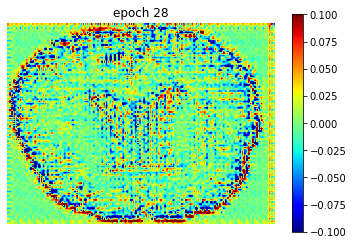

----------
epoch 30/40
1/9, train_loss: 0.0040
2/9, train_loss: 0.0038
3/9, train_loss: 0.0036
4/9, train_loss: 0.0039
5/9, train_loss: 0.0037
6/9, train_loss: 0.0036
7/9, train_loss: 0.0036
8/9, train_loss: 0.0037
9/9, train_loss: 0.0040
epoch 30 average loss: 0.0038


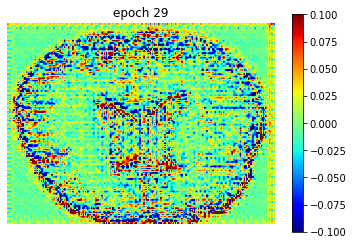

saved new best metric model
current epoch: 30 current mean MSE: 0.0036
best mean MSE: 0.0036 at epoch: 30
----------
epoch 31/40
1/9, train_loss: 0.0035
2/9, train_loss: 0.0035
3/9, train_loss: 0.0039
4/9, train_loss: 0.0037
5/9, train_loss: 0.0033
6/9, train_loss: 0.0043
7/9, train_loss: 0.0036
8/9, train_loss: 0.0037
9/9, train_loss: 0.0034
epoch 31 average loss: 0.0037


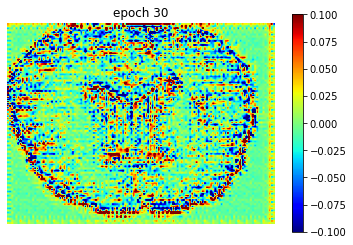

----------
epoch 32/40
1/9, train_loss: 0.0039
2/9, train_loss: 0.0040
3/9, train_loss: 0.0035
4/9, train_loss: 0.0034
5/9, train_loss: 0.0036
6/9, train_loss: 0.0031
7/9, train_loss: 0.0032
8/9, train_loss: 0.0035
9/9, train_loss: 0.0035
epoch 32 average loss: 0.0035


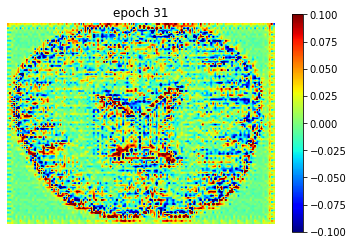

saved new best metric model
current epoch: 32 current mean MSE: 0.0034
best mean MSE: 0.0034 at epoch: 32
----------
epoch 33/40
1/9, train_loss: 0.0033
2/9, train_loss: 0.0034
3/9, train_loss: 0.0035
4/9, train_loss: 0.0035
5/9, train_loss: 0.0034
6/9, train_loss: 0.0042
7/9, train_loss: 0.0031
8/9, train_loss: 0.0033
9/9, train_loss: 0.0032
epoch 33 average loss: 0.0034


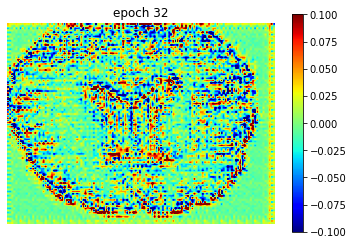

----------
epoch 34/40
1/9, train_loss: 0.0044
2/9, train_loss: 0.0032
3/9, train_loss: 0.0035
4/9, train_loss: 0.0031
5/9, train_loss: 0.0029
6/9, train_loss: 0.0037
7/9, train_loss: 0.0031
8/9, train_loss: 0.0031
9/9, train_loss: 0.0030
epoch 34 average loss: 0.0033


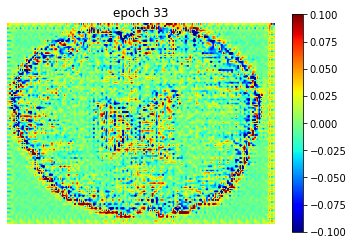

saved new best metric model
current epoch: 34 current mean MSE: 0.0032
best mean MSE: 0.0032 at epoch: 34
----------
epoch 35/40
1/9, train_loss: 0.0032
2/9, train_loss: 0.0033
3/9, train_loss: 0.0032
4/9, train_loss: 0.0033
5/9, train_loss: 0.0036
6/9, train_loss: 0.0029
7/9, train_loss: 0.0033
8/9, train_loss: 0.0032
9/9, train_loss: 0.0031
epoch 35 average loss: 0.0032


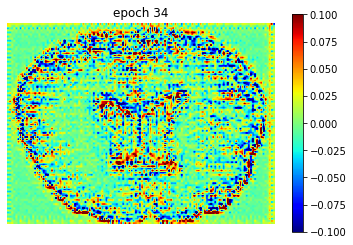

----------
epoch 36/40
1/9, train_loss: 0.0030
2/9, train_loss: 0.0030
3/9, train_loss: 0.0033
4/9, train_loss: 0.0033
5/9, train_loss: 0.0030
6/9, train_loss: 0.0031
7/9, train_loss: 0.0034
8/9, train_loss: 0.0029
9/9, train_loss: 0.0034
epoch 36 average loss: 0.0032


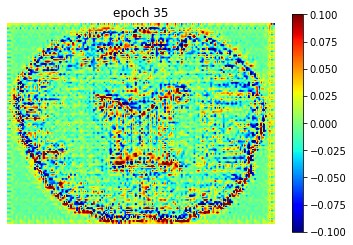

saved new best metric model
current epoch: 36 current mean MSE: 0.0030
best mean MSE: 0.0030 at epoch: 36
----------
epoch 37/40
1/9, train_loss: 0.0039
2/9, train_loss: 0.0032
3/9, train_loss: 0.0030
4/9, train_loss: 0.0028
5/9, train_loss: 0.0030
6/9, train_loss: 0.0030
7/9, train_loss: 0.0031
8/9, train_loss: 0.0028
9/9, train_loss: 0.0028
epoch 37 average loss: 0.0031


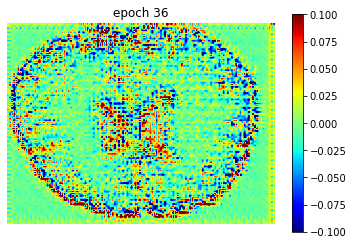

----------
epoch 38/40
1/9, train_loss: 0.0026
2/9, train_loss: 0.0030
3/9, train_loss: 0.0028
4/9, train_loss: 0.0028
5/9, train_loss: 0.0030
6/9, train_loss: 0.0028
7/9, train_loss: 0.0028
8/9, train_loss: 0.0036
9/9, train_loss: 0.0034
epoch 38 average loss: 0.0030


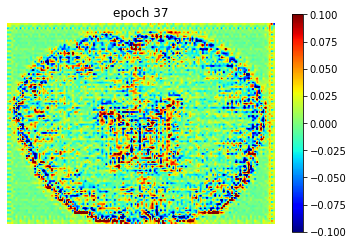

saved new best metric model
current epoch: 38 current mean MSE: 0.0029
best mean MSE: 0.0029 at epoch: 38
----------
epoch 39/40
1/9, train_loss: 0.0031
2/9, train_loss: 0.0025
3/9, train_loss: 0.0029
4/9, train_loss: 0.0035
5/9, train_loss: 0.0029
6/9, train_loss: 0.0028
7/9, train_loss: 0.0028
8/9, train_loss: 0.0032
9/9, train_loss: 0.0027
epoch 39 average loss: 0.0029


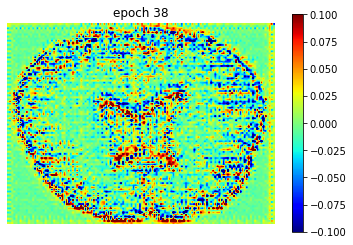

----------
epoch 40/40
1/9, train_loss: 0.0028
2/9, train_loss: 0.0035
3/9, train_loss: 0.0025
4/9, train_loss: 0.0026
5/9, train_loss: 0.0028
6/9, train_loss: 0.0026
7/9, train_loss: 0.0031
8/9, train_loss: 0.0029
9/9, train_loss: 0.0029
epoch 40 average loss: 0.0029


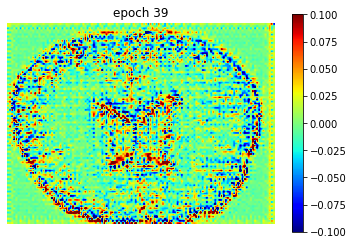

saved new best metric model
current epoch: 40 current mean MSE: 0.0028
best mean MSE: 0.0028 at epoch: 40


In [13]:
max_epochs = 40
val_interval = 2
best_metric = 0.1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
ignore_index = 0
post_pred = Compose([EnsureType()])
post_label = Compose([EnsureType()])
chosen_slice=80

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        #uncomment this when using SSIM loss
        #loss = 1-loss_function(outputs, labels)
        
        # Exclude background    
        mask = labels != ignore_index 
        loss = (loss * (mask).float()).sum() # gives signal euclidean over unmasked elements
        non_zero_elements = mask.sum()
        loss = loss / non_zero_elements

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    plt.title(f"epoch {epoch}")  
    plt.imshow(np.rot90(outputs[0].detach().cpu()[0, :, :, chosen_slice]),cmap="jet") 
    plt.clim(vmin=-0.1,vmax=0.1)
    plt.colorbar()
    plt.axis('off')
    plt.show()

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (128, 96, 128)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                mse_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean mse result
            metric = mse_metric.aggregate().item()
            # reset the status for next validation round
            mse_metric.reset()

            metric_values.append(metric)
            if metric < best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean MSE: {metric:.4f}"
                f"\nbest mean MSE: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

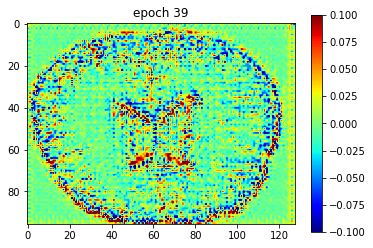

In [14]:
    plt.title(f"epoch {epoch}")  
    plt.imshow(np.rot90(outputs[0].detach().cpu()[0, :, :, chosen_slice]),cmap="jet") 
    plt.clim(vmin=-0.1,vmax=0.1)
    plt.colorbar()
    plt.show()

In [15]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.0028 at epoch: 40


## Plot the loss and metric

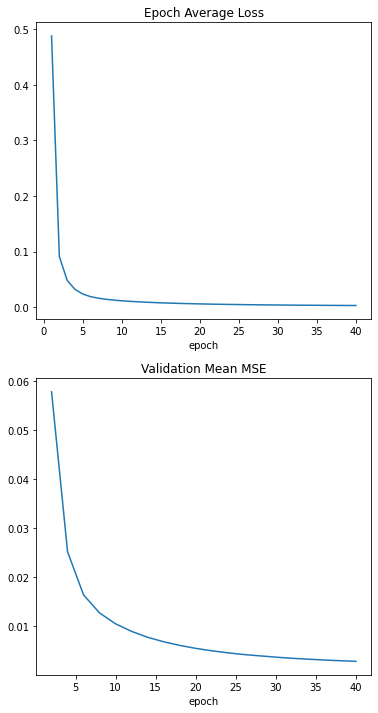

In [16]:
plt.figure("train", (6, 12))
plt.subplot(2, 1, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(2, 1, 2)
plt.title("Validation Mean MSE")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

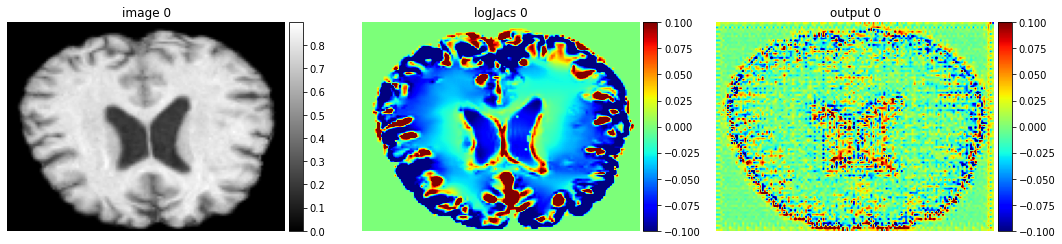

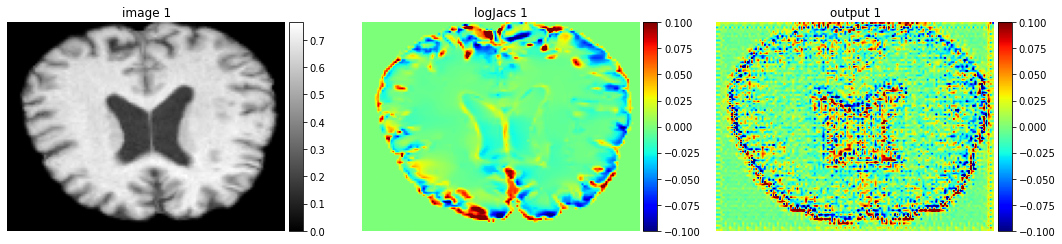

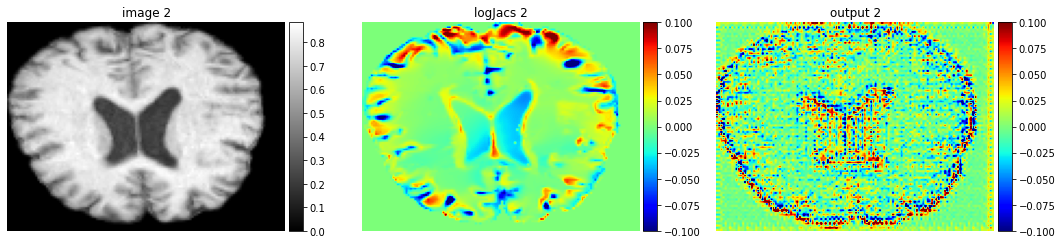

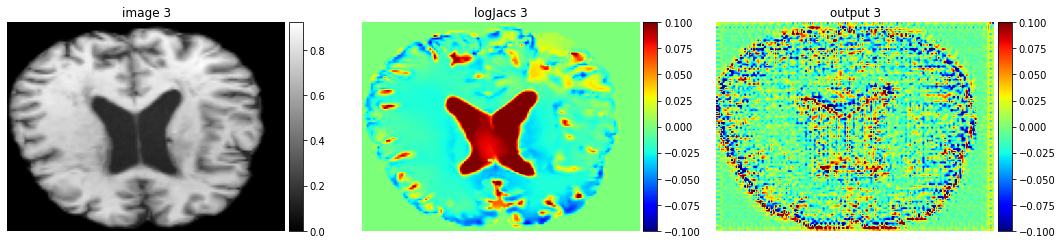

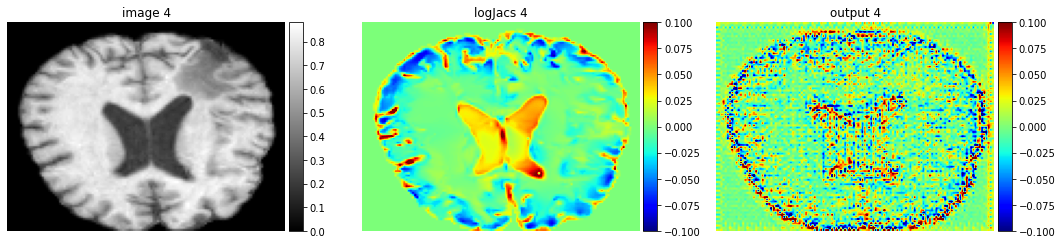

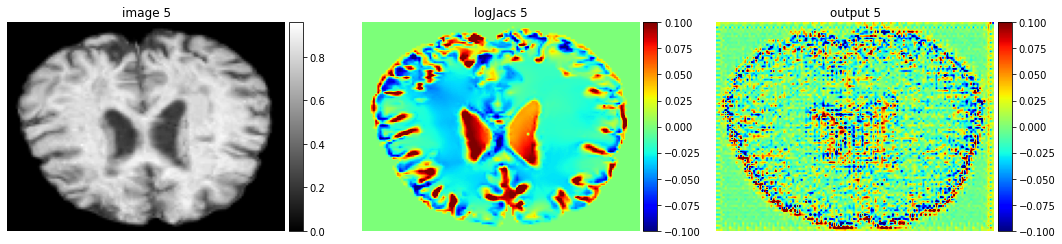

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (128, 96, 128)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        ax = plt.gca()
        im=plt.imshow(np.rot90(val_data["image"][0, 0, :, :, 80]), cmap="gray")
        plt.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        plt.subplot(1, 3, 2)
        plt.title(f"logJacs {i}")
        ax = plt.gca()
        im=plt.imshow(np.rot90(val_data["label"][0, 0, :, :, 80]), cmap="jet")
        plt.clim(vmin=-0.1, vmax=0.1)
        plt.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        ax = plt.gca()
        #plt.imshow(torch.argmax(
        #    val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
        im=plt.imshow(np.rot90(val_outputs[0].detach().cpu()[0, :, :, chosen_slice]),cmap="jet")
        plt.clim(vmin=-0.1, vmax=0.1)
        plt.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        plt.show()
        if i == 5:
            break

## Evaluation on original image spacings

In [18]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        #Spacingd(keys=["image"], pixdim=(
        #    1.5, 1.5, 2.0), mode="bilinear"),
        #ScaleIntensityRanged(
        #    keys=["image"], a_min=-57, a_max=164,
        #    b_min=0.0, b_max=1.0, clip=True,
        #),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

val_org_ds = Dataset(
    data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    AsDiscreted(keys="label", to_onehot=2),
])

In [19]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (128, 96, 128)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        mse_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = mse_metric.aggregate().item()
    # reset the status for next validation round
    mse_metric.reset()

print("Metric on original image spacing: ", metric_org)

RuntimeError: ignored

## Inference on Test Set

In [ ]:
#test_images = sorted(
#    glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

test_images = sorted(glob.glob(os.path.join(root_dir, "im*.nii.gz")))
test_images = test_images[80:]
test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys="image"),
    ]
)

test_org_ds = Dataset(
    data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose([
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=test_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
])

In [ ]:
# # uncomment the following lines to visualize the predicted results
from monai.transforms import LoadImage
loader = LoadImage()

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (128, 96, 128)
        sw_batch_size = 2
        test_data["pred"] = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
        test_output = from_engine(["pred"])(test_data)

        original_image = loader(test_data[0]["image_meta_dict"]["filename_or_obj"])[0]

        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image[:, :, 80], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.imshow(test_output[0].detach().cpu()[1, :, :, 80])
        plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)